In [112]:
#pip install scikit-optimize

     ------------------------------------ 100.3/100.3 kB 957.7 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Load the required libraries

In [105]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, optimizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam, RMSprop
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Load the data from the cleaned data source file

In [2]:
#Load dataset into a pandas dataframe
data = pd.read_csv("Cleaned data/data.csv") 

# don't really need to do this as this is cleaned data
data.dropna(inplace = True)

data.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,MIN,MAX,RAIN,SOLAR,RRP,FORECASTDEMAND,OUTPUT,MONTHDATE,WEEKDAY,WEEKEND,TEMPAVE
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,15.3,28.6,0.0,32.2,38.472917,6665.366167,23.465,01-2016,4,0,21.95
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,15.9,26.1,0.0,21.7,36.907292,6236.849955,23.465,01-2016,5,1,21.00
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,17.5,25.6,0.0,10.3,31.997083,6551.924748,23.465,01-2016,6,1,21.55
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,18.2,23.6,14.0,6.4,33.424583,6729.993123,23.465,01-2016,0,0,20.90
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,17.6,20.5,39.0,4.4,33.053958,7333.898202,23.465,01-2016,1,0,19.05


Drop the un-needed features

In [3]:
# df = data.drop(['MIN','MAX','FORECASTDEMAND', 'MONTHDATE','WEEKEND','RAIN'], axis=1)
df = data.drop(['MIN','MAX', 'MONTHDATE','WEEKEND'], axis=1)
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,RAIN,SOLAR,RRP,FORECASTDEMAND,OUTPUT,WEEKDAY,TEMPAVE
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,0.0,32.2,38.472917,6665.366167,23.465,4,21.95
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,0.0,21.7,36.907292,6236.849955,23.465,5,21.00
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,0.0,10.3,31.997083,6551.924748,23.465,6,21.55
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,14.0,6.4,33.424583,6729.993123,23.465,0,20.90
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,39.0,4.4,33.053958,7333.898202,23.465,1,19.05


One-hot encoding of categorical variables

In [4]:
# One-hot Encoding for categorial data (Weekday)

# Select the "WEEKDAY" column and create a new dataframe
weekday_df = df[['WEEKDAY']]

# Create a one-hot encoder object
encoder = OneHotEncoder(categories='auto')

# Fit and transform the weekday data
weekday_encoded = encoder.fit_transform(df[['WEEKDAY']]).toarray()

# Create a new dataframe with the encoded weekday data
weekday_df = pd.DataFrame(weekday_encoded, columns=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'])

#Drop the weekday column
df = df.drop(['WEEKDAY'], axis=1)

# Concatenate the original dataframe with the encoded weekday dataframe
df = pd.concat([df, weekday_df], axis=1)

df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,RAIN,SOLAR,...,FORECASTDEMAND,OUTPUT,TEMPAVE,MON,TUE,WED,THU,FRI,SAT,SUN
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,0.0,32.2,...,6665.366167,23.465,21.95,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,0.0,21.7,...,6236.849955,23.465,21.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,0.0,10.3,...,6551.924748,23.465,21.55,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,14.0,6.4,...,6729.993123,23.465,20.90,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,39.0,4.4,...,7333.898202,23.465,19.05,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Convert the 'date' column to a datetime object
df['DATE'] = pd.to_datetime(df['DATE'])

# Set 'DATE' as the index
df.set_index('DATE', inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2376 entries, 2016-01-01 to 2022-08-01
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   YEAR            2376 non-null   int64  
 1   MONTH           2376 non-null   int64  
 2   DAY             2376 non-null   int64  
 3   HUMIDITY        2376 non-null   float64
 4   WINDSPEED       2376 non-null   float64
 5   TOTALDEMAND     2376 non-null   float64
 6   HOLIDAY         2376 non-null   float64
 7   RAIN            2376 non-null   float64
 8   SOLAR           2376 non-null   float64
 9   RRP             2376 non-null   float64
 10  FORECASTDEMAND  2376 non-null   float64
 11  OUTPUT          2376 non-null   float64
 12  TEMPAVE         2376 non-null   float64
 13  MON             2376 non-null   float64
 14  TUE             2376 non-null   float64
 15  WED             2376 non-null   float64
 16  THU             2376 non-null   float64
 17  FRI            

Split the dataset into training and testing sets
<br>Note: 
- training is from August 2017 - July 2021 (inclusive)
- testing is from August 2021 - July 2022 (inclusive) 

In [7]:
df_train = df[(df.index >= datetime(2017, 8, 1)) & (df.index < datetime(2021, 8, 1))]
df_test = df[df.index >= datetime(2021, 8, 1)]

demand_train_df = df_train[['TOTALDEMAND','FORECASTDEMAND']]
demand_test_df = df_test[['TOTALDEMAND','FORECASTDEMAND']]

df_train.drop(['FORECASTDEMAND'], axis=1)
df_test.drop(['FORECASTDEMAND'], axis=1)

train_X = df_train.drop('TOTALDEMAND', axis=1)
train_y = df_train['TOTALDEMAND']

test_X = df_test.drop('TOTALDEMAND', axis=1)
test_y = df_test['TOTALDEMAND']

print("number of training records",len(train_X))
print("number of test records",len(test_X))

X_train = train_X.values
y_train = train_y.values

X_test = test_X.values
y_test = test_y.values

number of training records 1461
number of test records 337


Normalize the data

In [8]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

print("X_train_scaled:", len(X_train_scaled))
print("X_test_scaled:", len(X_test_scaled))

scaler_Y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_Y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_Y.transform(y_test.reshape(-1, 1))

print("y_train_scaled:", len(y_train_scaled))
print("y_test_scaled:", len(y_test_scaled))

X_train_scaled: 1461
X_test_scaled: 337
y_train_scaled: 1461
y_test_scaled: 337


Reshape the data for input to the LSTM model 

In [9]:
X_train.shape

(1461, 19)

In [10]:
#(This step will fit the data to a 3D tensor format for the LSTM model to process the sequential data efficiently 
#and capture any temporal dependencies in the data)

#we using sliding window approach to create input-output pairs with
#timesteps n = 1

X_train = []
y_train = []
for i in range(1, len(X_train_scaled)):
    X_train.append(X_train_scaled[i, :])
    y_train.append(y_train_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))

X_test = []
y_test = []
for i in range(1, len(X_test_scaled)):
    X_test.append(X_test_scaled[i,:])
    y_test.append(y_test_scaled[i])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

X_train.shape

(1460, 19)

In [11]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (1460, 19)
y_train:  (1460, 1)
X_test:  (336, 19)
y_test:  (336, 1)


In [20]:
X_train.shape

(1460, 1, 19)

We use a Bayesian optimisation process to find the optimum combination of hyperparameters for this model
(Note: we are using the scikit-optimize library) 

In [19]:
# Assuming X_train and X_test are numpy arrays
X_train = X_train.reshape((X_train.shape[0], timesteps, input_dim))
X_test = X_test.reshape((X_test.shape[0], timesteps, input_dim))

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from skopt import gp_minimize
from skopt.space import Real, Integer, Space, Categorical
from skopt.utils import use_named_args

# Setting the input and output dimensions and timesteps for the forecast
input_dim = X_train.shape[2]
output_dim = 1
timesteps = 1

# Define a function to create the LSTM model
def create_lstm_model(lr, n_units1, n_units2, n_units3, n_units4, dropout_rate1, dropout_rate2, dropout_rate3, dropout_rate4, activation1, activation2, activation3, activation4):
    model = Sequential()
    model.add(LSTM(units=n_units1, input_shape=(timesteps, input_dim), return_sequences=True, activation=activation1))
    model.add(Dropout(dropout_rate1))
    model.add(LSTM(units=n_units2, activation=activation2, return_sequences=True))
    model.add(Dropout(dropout_rate2))
    model.add(LSTM(units=n_units3, activation=activation3, return_sequences=True))
    model.add(Dropout(dropout_rate3))
    model.add(LSTM(units=n_units4, activation=activation4))
    model.add(Dropout(dropout_rate4))
    model.add(Dense(output_dim))

    optimizer = Adam(learning_rate=lr)
    model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
    
    return model

# Define the function to optimize
@use_named_args([
    Real(1e-5, 1e-2, "log-uniform", name='learning_rate'),
    Integer(64, 1024, name='n_units1'),
    Integer(64, 1024, name='n_units2'),
    Integer(64, 1024, name='n_units3'),
    Integer(64, 1024, name='n_units4'),
    Integer(0, 5, name='dropout_rate1'),
    Integer(0, 5, name='dropout_rate2'),
    Integer(0, 5, name='dropout_rate3'),
    Integer(0, 5, name='dropout_rate4'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation1'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation2'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation3'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation4')
])

def optimize_lstm(learning_rate, 
                  n_units1, n_units2, n_units3, n_units4,    
                  dropout_rate1, dropout_rate2, dropout_rate3, dropout_rate4,
                  activation1, activation2, activation3, activation4):
    
    dropout_rate1 = dropout_rate1/10
    dropout_rate2 = dropout_rate2/10
    dropout_rate3 = dropout_rate3/10
    dropout_rate4 = dropout_rate4/10
    
    # Create the model
    model = create_lstm_model(learning_rate, 
                              n_units1, n_units2, n_units3, n_units4,  
                              dropout_rate1, dropout_rate2, dropout_rate3, dropout_rate4, 
                              activation1, activation2, activation3, activation4)
    
    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                        epochs=50, batch_size=64, verbose=0, callbacks=[early_stopping])
    
    # Get the validation MAE from the last epoch
    val_mae = history.history['val_mae'][-1]
    
    return val_mae

# Set up early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Define the search space
search_space = Space([
    Real(1e-5, 1e-2, "log-uniform", name='learning_rate'),
    Integer(64, 1024, name='n_units1'),
    Integer(64, 1024, name='n_units2'),
    Integer(64, 1024, name='n_units3'),
    Integer(64, 1024, name='n_units4'),
    Integer(0, 5, name='dropout_rate1'),
    Integer(0, 5, name='dropout_rate2'),
    Integer(0, 5, name='dropout_rate3'),
    Integer(0, 5, name='dropout_rate4'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation1'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation2'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation3'),
    Categorical(['tanh', 'relu', 'sigmoid'], name='activation4')
])

# Run the Bayesian optimization
result = gp_minimize(optimize_lstm, search_space, n_calls=50, random_state=42)

# extract the best hyperparameters
best_learning_rate, best_n_units1, best_n_units2, best_n_units3, best_n_units4, best_dropout_rate1, best_dropout_rate2, best_dropout_rate3, best_dropout_rate4, best_activation1, best_activation2, best_activation3, best_activation4 = result.x

In [47]:
best_dropout_rate1 = best_dropout_rate1/10
best_dropout_rate2 = best_dropout_rate2/10
best_dropout_rate3 = best_dropout_rate3/10
best_dropout_rate4 = best_dropout_rate4/10

# Print the optimal hyperparameters
print(f"best_learning_rate = {best_learning_rate}")
print(f"best_n_units1 = {best_n_units1}")
print(f"best_n_units2 = {best_n_units2}")
print(f"best_n_units3 = {best_n_units3}")
print(f"best_n_units3 = {best_n_units4}")
print(f"best_activation1 = '{best_activation1}'")
print(f"best_activation2 = '{best_activation2}'")
print(f"best_activation3 = '{best_activation3}'")
print(f"best_activation3 = '{best_activation4}'")
print(f"best_dropout_rate1 = {best_dropout_rate1}")
print(f"best_dropout_rate2 = {best_dropout_rate2}")
print(f"best_dropout_rate3 = {best_dropout_rate3}")
print(f"best_dropout_rate3 = {best_dropout_rate4}")

best_learning_rate = 0.004207799011940952
best_n_units1 = 784
best_n_units2 = 1024
best_n_units3 = 87
best_n_units3 = 1024
best_activation1 = 'tanh'
best_activation2 = 'tanh'
best_activation3 = 'sigmoid'
best_activation3 = 'relu'
best_dropout_rate1 = 0.4
best_dropout_rate2 = 0.5
best_dropout_rate3 = 0.2
best_dropout_rate3 = 0.0


In [12]:
# best_learning_rate = 0.004207799011940952
# best_n_units1 = 784
# best_n_units2 = 1024
# best_n_units3 = 87
# best_n_units3 = 1024
# best_activation1 = 'tanh'
# best_activation2 = 'tanh'
# best_activation3 = 'sigmoid'
# best_activation3 = 'relu'
# best_dropout_rate1 = 0.4
# best_dropout_rate2 = 0.5
# best_dropout_rate3 = 0.2
# best_dropout_rate3 = 0.0

Build the final LSTM model with the optimal hyperparameters selected

In [48]:
# setup the model 
timesteps=X_train.shape[1]
input_dim=X_train.shape[2]
output_dim=1

# Build the LSTM model with 1 input layer, 2 hidden LSTM layers and one Dense output layer
# using the best combination of hyperparameters as derived above
model = Sequential()
model.add(LSTM(units=best_n_units1, input_shape=(timesteps, input_dim), return_sequences=True, activation=best_activation1))
model.add(Dropout(best_dropout_rate1))
model.add(LSTM(units=best_n_units2, activation=best_activation2, return_sequences=True))
model.add(Dropout(best_dropout_rate2))
model.add(LSTM(units=best_n_units3, activation=best_activation3, return_sequences=True))
model.add(Dropout(best_dropout_rate3))
model.add(LSTM(units=best_n_units4, activation=best_activation4))
model.add(Dropout(best_dropout_rate4))
model.add(Dense(output_dim))

optimizer=Adam(learning_rate=best_learning_rate)
model.compile(loss='mae', optimizer=optimizer)

In [49]:
#set the model to stop early if it appears to converge (decided on 20 iterations with no changes)
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20) 

# Train the LSTM model on the olptimum model definition
history = model.fit(X_train, y_train, epochs=45, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/45
46/46 [==============================] - 12s 135ms/step - loss: 0.1588 - val_loss: 0.1182
Epoch 2/45
46/46 [==============================] - 5s 117ms/step - loss: 0.1211 - val_loss: 0.1199
Epoch 3/45
46/46 [==============================] - 6s 125ms/step - loss: 0.1219 - val_loss: 0.1462
Epoch 4/45
46/46 [==============================] - 6s 124ms/step - loss: 0.1183 - val_loss: 0.1543
Epoch 5/45
46/46 [==============================] - 6s 129ms/step - loss: 0.1138 - val_loss: 0.1444
Epoch 6/45
46/46 [==============================] - 6s 127ms/step - loss: 0.1024 - val_loss: 0.1378
Epoch 7/45
46/46 [==============================] - 6s 127ms/step - loss: 0.0985 - val_loss: 0.1203
Epoch 8/45
46/46 [==============================] - 6s 137ms/step - loss: 0.1040 - val_loss: 0.1187
Epoch 9/45
46/46 [==============================] - 6s 129ms/step - loss: 0.0920 - val_loss: 0.1679
Epoch 10/45
46/46 [==============================] - 6s 129ms/step - loss: 0.0938 - val_loss: 0.104

Run the prediction on the test set

In [50]:
# Make predictions on the test set
y_pred = model.predict(X_test)

11/11 [==============================] - 1s 10ms/step


In [51]:
# Evaluate the LSTM model on the test set
# Calculate MAE, MSE and R-squared

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Number of predictions: %d' % len(y_pred))
print('MAE: %.4f' % mae)
print('MSE: %.4f' % mse)
print('R-squared: %.4f' % r2)

Number of predictions: 336
MAE: 0.0589
MSE: 0.0057
R-squared: 0.8354


Plot the loss function (MAE) against the training and test data 

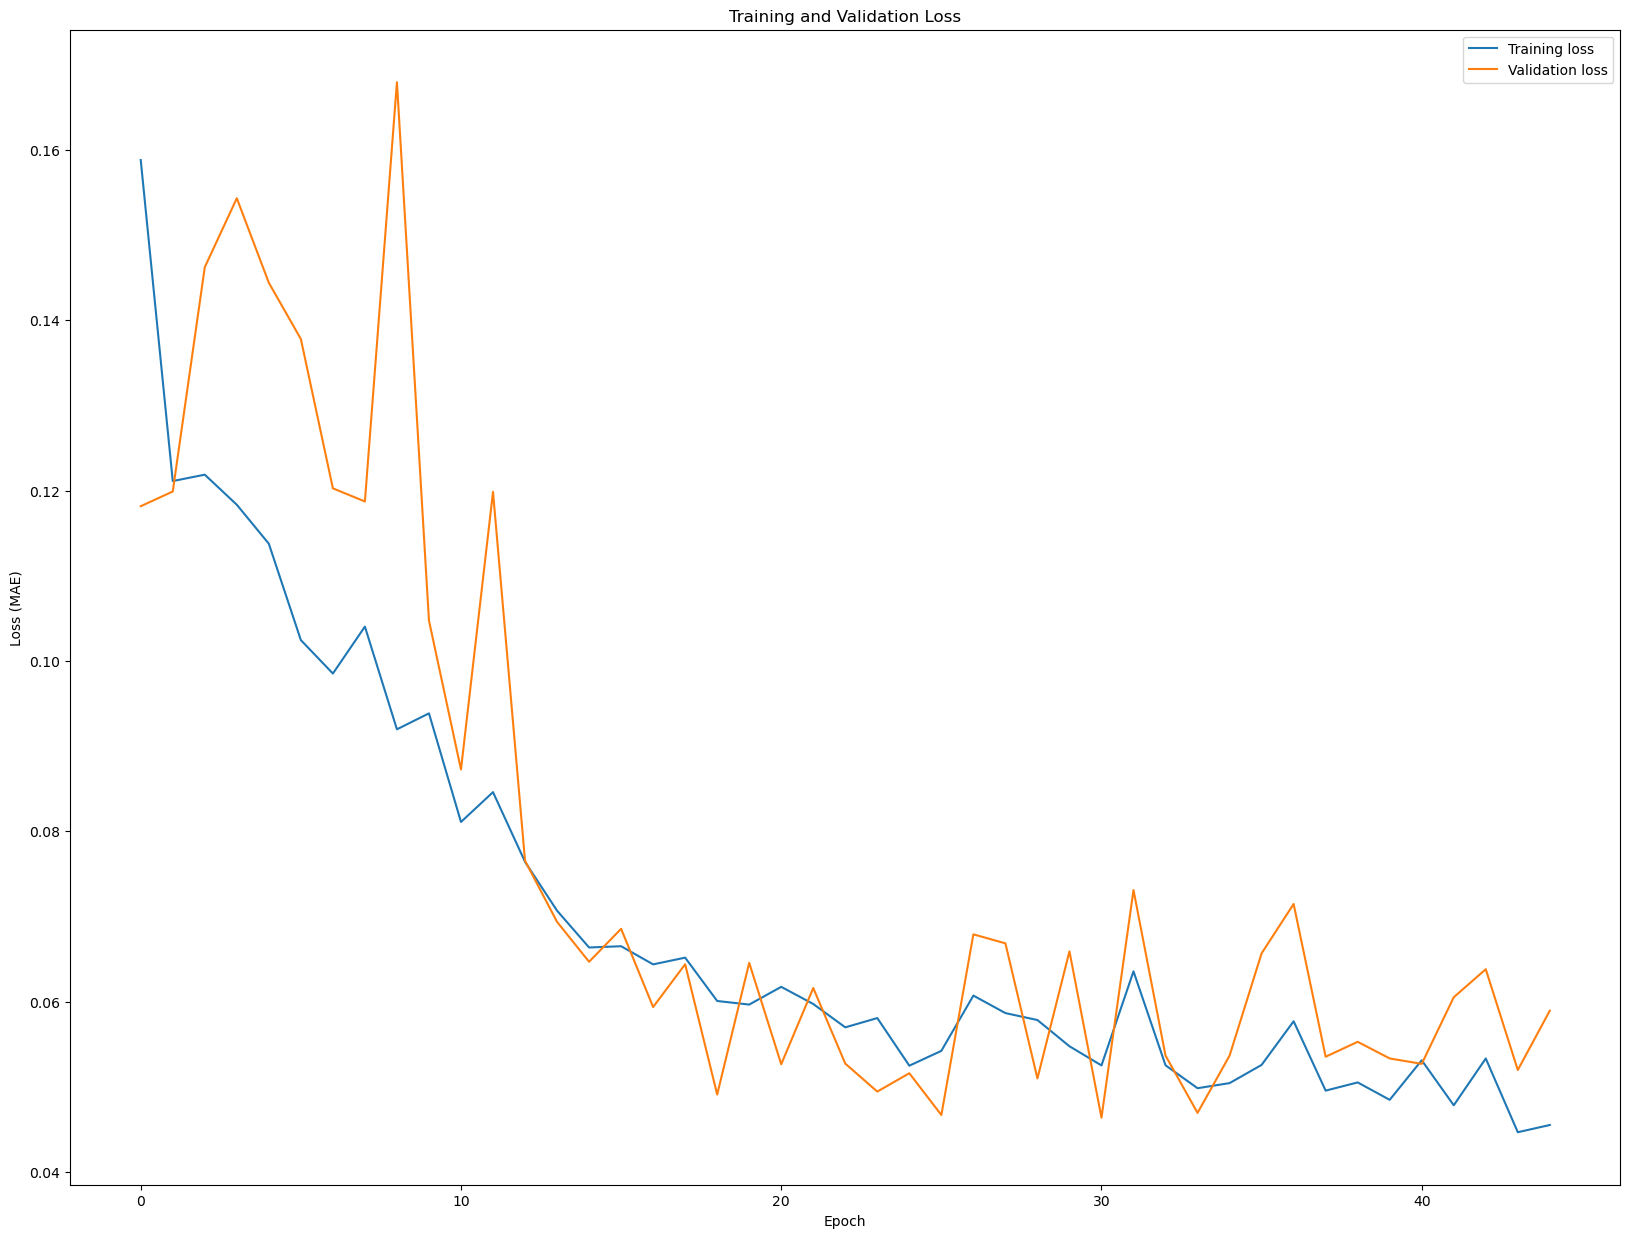

In [52]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

# Plot training and validation loss (MAE) for each epoch
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

In [53]:
# revert the predicted values to actual values
y_pred_reverted = scaler_Y.inverse_transform(y_pred)

y_pred_reverted = list(y_pred_reverted.flatten())
y_pred_reverted.insert(0, None)

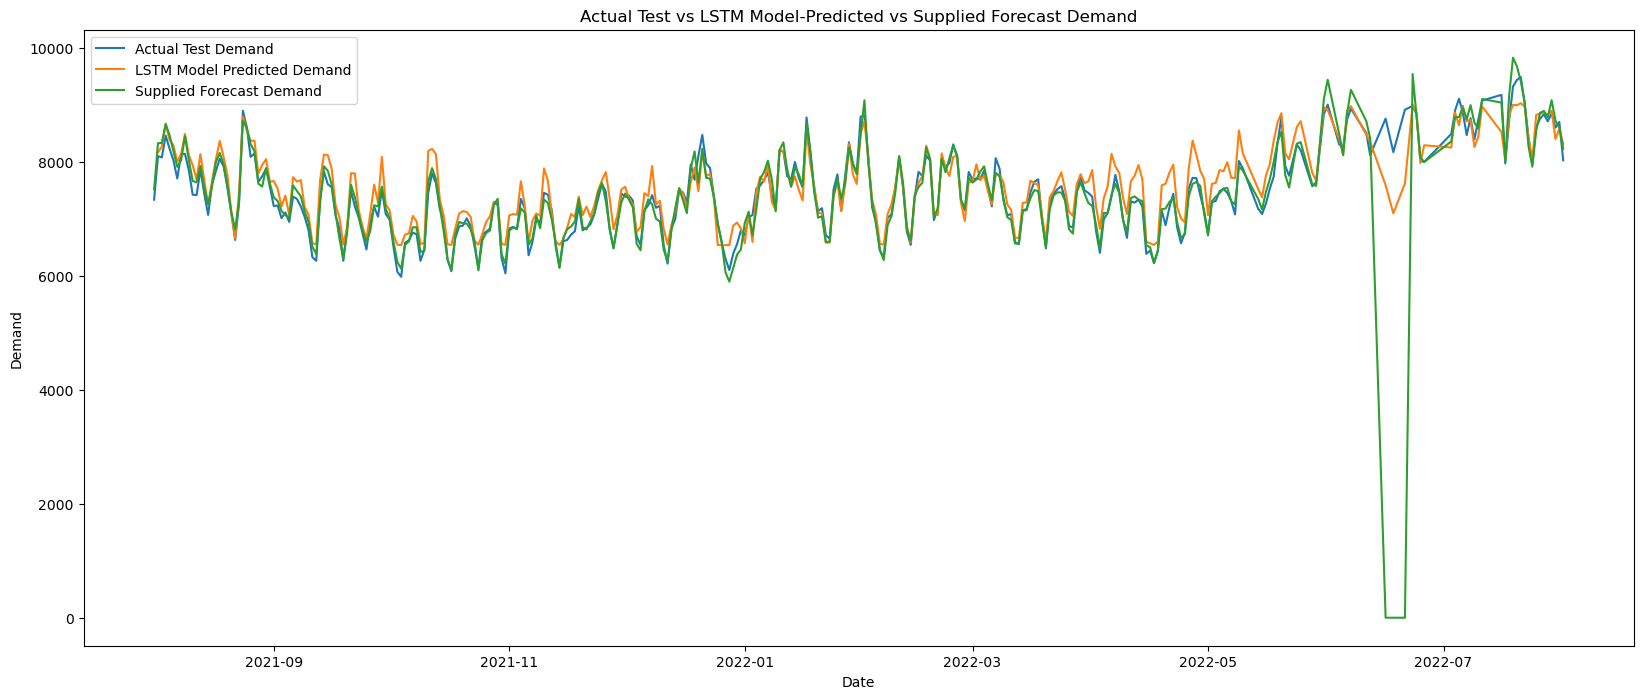

In [98]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

test_set_df = demand_test_df.copy()
test_set_df['Pred_Demand'] = y_pred_reverted

# Plot training and validation loss (MAE) for each epoch
plt.rcParams["figure.figsize"] = (20,8)
plt.plot(test_set_df.index, test_set_df.TOTALDEMAND, label='Actual Test Demand')
plt.plot(test_set_df.index, test_set_df.Pred_Demand, label='LSTM Model Predicted Demand')
plt.plot(test_set_df.index, test_set_df.FORECASTDEMAND, label='Supplied Forecast Demand')
plt.title('Actual Test vs LSTM Model-Predicted vs Supplied Forecast Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

Approximation Model

Try a Random Forest Regressor

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from sklearn import set_config 

In [119]:
df_test_copy = df_test.copy()

df_test_copy['Predicted_Demand'] = test_set_df['Pred_Demand']
df_test_copy.drop(columns=['FORECASTDEMAND'], inplace=True)

feature_cols = df_test_copy.columns[:-1]

df_test_copy.dropna(axis=0, inplace=True)
test_training = df_test_copy[(df_test_copy.index >= datetime(2021, 8, 1)) & (df_test_copy.index < datetime(2022, 6, 1))]
test_validation = df_test_copy[df_test_copy.index >= datetime(2022, 6, 1)]

scaler_Xtest = MinMaxScaler(feature_range=(0, 1))
X_train_test_scaled = scaler_Xtest.fit_transform(test_training.drop(['Predicted_Demand'], axis=1).values)
X_validation_test_scaled = scaler_Xtest.transform(test_validation.drop(['Predicted_Demand'], axis=1).values)

print("X_train_test_scaled:", len(X_train_test_scaled))
print("X_validation_test_scaled:", len(X_validation_test_scaled))

scaler_Ytest = MinMaxScaler(feature_range=(0, 1))
y_train_test_scaled = scaler_Ytest.fit_transform(test_training['Predicted_Demand'].values.reshape(-1, 1))
y_validation_test_scaled = scaler_Ytest.transform(test_validation['Predicted_Demand'].values.reshape(-1, 1))

print("y_train_test_scaled:", len(y_train_test_scaled))
print("y_validation_test_scaled:", len(y_validation_test_scaled))

rfr = RandomForestRegressor()
print(rfr)

X_train_test_scaled_df = pd.DataFrame(X_train_test_scaled)
y_train_test_scaled_df = pd.DataFrame(y_train_test_scaled)

rfr.fit(X_train_test_scaled, y_train_test_scaled.flatten())

score = rfr.score(X_train_test_scaled, y_train_test_scaled.flatten())
print("R-squared:", score) 

X_train_test_scaled_df.columns = feature_cols
feat_imp_df = pd.DataFrame(rfr.feature_importances_).T
feat_imp_df.columns = feature_cols

feat_imp_df = feat_imp_df.T
feat_imp_df.columns = ['feature importance']

X_train_test_scaled: 296
X_validation_test_scaled: 40
y_train_test_scaled: 296
y_validation_test_scaled: 40
RandomForestRegressor()
R-squared: 0.9904352688152179


<Axes: >

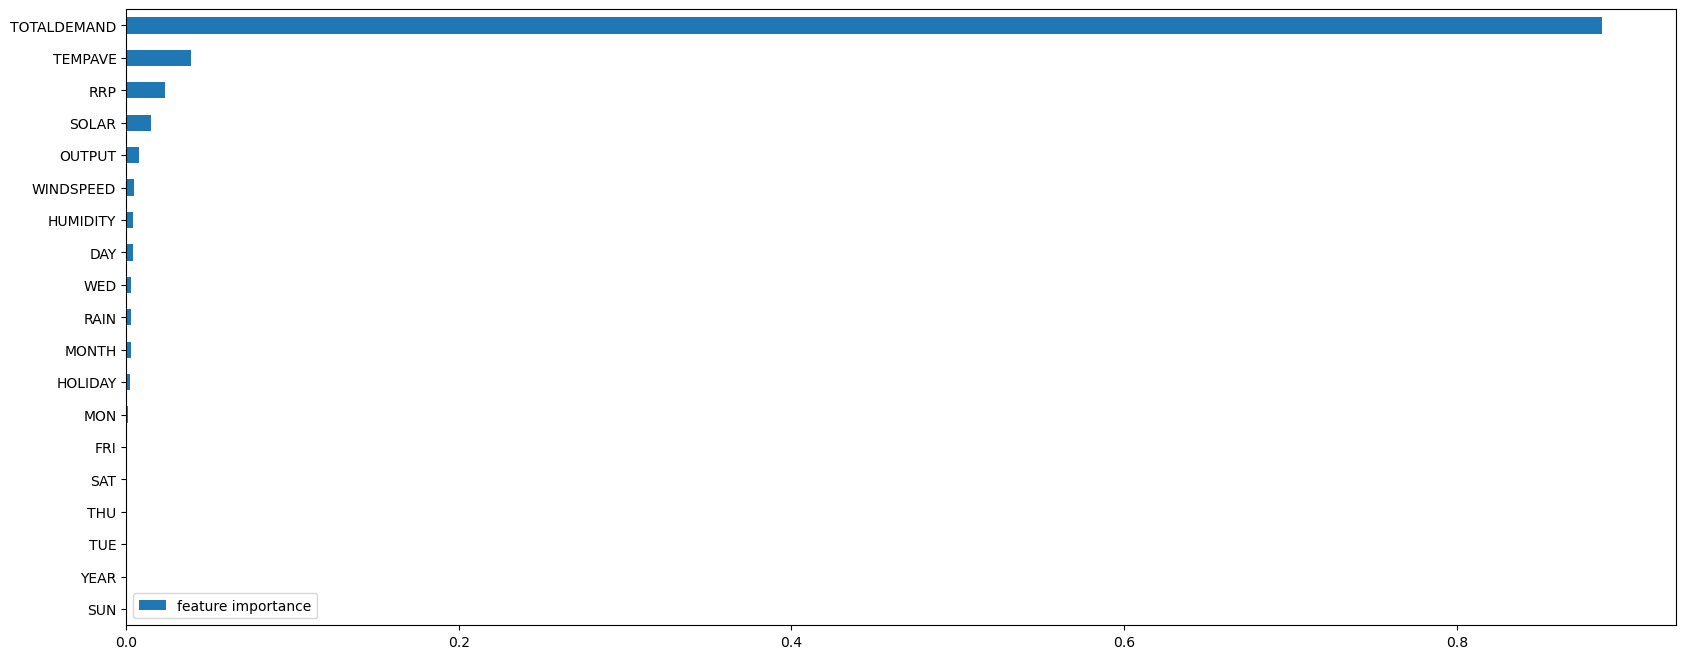

In [102]:
plt.rcParams["figure.figsize"] = (20,8)
feat_imp_df.sort_values(by='feature importance', ascending=True).plot.barh()

In [120]:
feat_imp_df.sort_values(by='feature importance', ascending=False)

,feature importance
TOTALDEMAND,0.887154
TEMPAVE,0.038927
RRP,0.021615
SOLAR,0.015262
OUTPUT,0.008952
WINDSPEED,0.005093
DAY,0.004268
HUMIDITY,0.004150
MONTH,0.003298
WED,0.002910
